# Simon's Algorithm

> **Simon's algorithm** [\[1\]](#original-paper), [\[2\]](#SimonsWiki) is a basic quantum algorithm that demonstrates an exponential speed-up$^*$ over its classical counterpart in the oracle complexity setting. The algorithm solves the so-called Simon's problem: 
>
> The algorithm treats the following problem:
>
> - **Input:** A function $f: [0,1]^n \rightarrow [0,1]^n$.
> - **Promise:** There is a secret binary string $s$ such that $f(x) = f(y) \iff   y = x\oplus s\tag{1}~~,$ where $\oplus$ is a bitwise xor operation.
> - **Output:** The secret string $s$, using a minimal number of queries of $f$.
>
> **Complexity:** The Simon's problem is hard to solve with classical deterministic or probabalistic approaches. This can be understood as follows: determining $s$ requires finding a collision $f(x)=f(y)$, as $s = x\oplus y$. What is the minimum number of calls for measuring a collision? If we take the deterministic approach, in the worst case we need $2^{n-1}$ calls. A probablistic approach, in the spirit of the one that solves the birthday problem [<a href="#BDWiki">3</a>], has slightly better scaling of $O(2^{n/2})$ queries. The quantum approach requires $O(n)$ queries, thus introducing an exponential speedup.
>
> $^*$ The exponential speedup is in the oracle complexity setting. It only refers to deterministic classical machines.
>
> ---
>
> **Keywords:**  Foundational quantum algorithm, Exponential speedup, Function evaluation, Oracle problem, Oracle/Query complexity. 


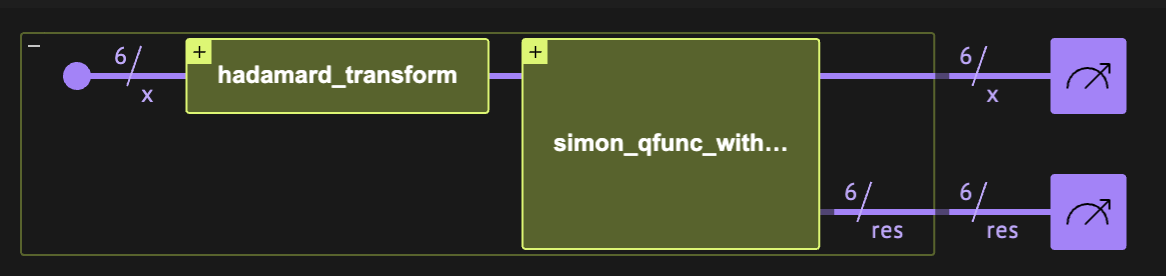
<center>
<figcaption align = "middle"> Figure 1. The Simon's algorithm comprises two quantum blocks. The main part of the algorithm
is the oracle that implements the Simon's function f(x). </figcaption>
</center>

In the following notebook we define the Simon's algorithm, which has a [quantum part](#The-Quantum-Part) and a [classical postprocess part](#The-Classical-Postprocess). Then, we run the algorithm on two different examples of a Simon's function: one that can be defined with [simple arithmetic](#Example:-Arithmetic-Simon's-Function) and another that has a [shallow implementation](#Example:-Shallow-Simon's-Function). A [mathematical explanation](#Technical-Notes) of the algorithm is provided at the end of this notebook.

Note that the function $f$ is  $2$-to-$1$ if $s\neq 0^n$, and $1$-to-$1$ otherwise. Hereafter, we refer to a function that satisfies the condition in Eq. (1) as a "Simon's function".

## Building the Algorithm with Classiq

### Quantum Part

The quantum part of the algorithm is rather simple, calling the quantum implementation of $f(x)$, between two calls of the hadamard transform. The call of $f$ is done out-of-place, onto a quantum variable $y$, whereas only the final state of $x$ is relevant to the classical postprocess to follow. 

In [1]:
from classiq import *


@qfunc
def simon_qfunc(f_qfunc: QCallable[QNum, Output[QNum]], x: QNum):
    res = QNum()
    within_apply(lambda: hadamard_transform(x), lambda: f_qfunc(x, res))

### Classical Postprocess

The classical part of the algorithm includes the following postprocessing steps:

1. Finding $n-1$ samples of $x$ that are linearly independent, $\{y_k\}^{n-1}_{1}$. It is guaranteed that this can be achieved with high probability (see the [technical details](#The-classical-part) below).
2. Finding the string $s$ such that $s \cdot y_k=0 \,\,\, \forall k$, where $\cdot$ refers to a dot-product $\text{mod}~ 2$ (polynomial complexity in $n$).

For these steps we use the *Galois* package, which extends *NumPy* to finite field operations.

In [2]:
# !pip install galois

In [3]:
import galois
import numpy as np

# here we work over Boolean arithmetics - F(2)
GF = galois.GF(2)

We define two classical functions for the first step: 

In [4]:
# The following function checks whether a set contains linearly independent vectors


def is_independent_set(vectors):
    matrix = GF(vectors)
    rank = np.linalg.matrix_rank(matrix)
    if rank == len(vectors):
        return True
    else:
        return False


def get_independent_set(samples):
    """
    The following function gets samples of n-sized strings from running the quantum part and returns an n-1 x n matrix,
    whose rows form a set if independent.
    """
    ind_v = []
    for v in samples:
        if is_independent_set(ind_v + [v]):
            ind_v.append(v)
            if len(ind_v) == len(v) - 1:
                # reached max set of N-1
                break
    return ind_v

For the second step we need to solve a linear set of equations. We have $n-1$ equations on a binary vector of size $n$.
It has two solutions, one of which is the trivial solution $0^n$, while the other gives us the secret string $s$. The *Galois* package handles this task as follows:

In [5]:
def get_secret_integer(matrix):
    """
    Finds a binary vector that “solves” the equation
    Ax=0 (mod 2) —
    and then turns that vector into a single integer, which serves as the “secret”.
    """
    gf_v = GF(matrix)  # converting to a matrix over Z_2
    null_space = gf_v.T.left_null_space()  # finding the right-null space of the matrix
    return int(
        "".join(np.array(null_space)[0][::-1].astype(str)), 2
    )  # converting from binary to integer

---

Next, we provide two different examples of Simon's function and run the Simon's algorithm to find their secret string.

---

## Example: Arithmetic Simon's Function

An example of a valid $f(x)$ function that satisfies the condition in Eq. ([1](#mjx-eqn-1)):
$$
f(x) = \min(x, x\oplus s).
$$
Clearly, we have that $f(x\oplus s) = \min(x\oplus s, (x\oplus s)\oplus s)=\min(x\oplus s, x)=f(x)$.

### Implementing the Simon's Function

We define the function, as well as a model that applies it on all computational basis states to illustrate that it is a two-to-one function.

In [6]:
from classiq.qmod.symbolic import min


@qperm
def simon_qfunc_simple(s: CInt, x: Const[QNum], res: Output[QNum]):
    res |= min(x, x ^ s)

Let us run it with $n=5$ and $s={'}00110{'} (\equiv 6)$, starting with a uniform distribution of $|x\rangle$ over all possible states:

In [7]:
NUM_QUBITS = 5
S_SECRET = 6


@qfunc
def main(x: Output[QNum[NUM_QUBITS]], res: Output[QNum]):
    allocate(x)
    hadamard_transform(x)
    simon_qfunc_simple(S_SECRET, x, res)


qmod_1 = create_model(main)

# synthesize
qprog_1 = synthesize(
    qmod_1, constraints=Constraints(optimization_parameter=OptimizationParameter.WIDTH)
)
# vizualize
show(qprog_1)

# execute
result_1 = execute(qprog_1).result_value()

Quantum program link: https://platform.classiq.io/circuit/34mVBiiOR198FdovL4Dzq8tAMOw


By plotting the results we can see that this is a two-to-one function:

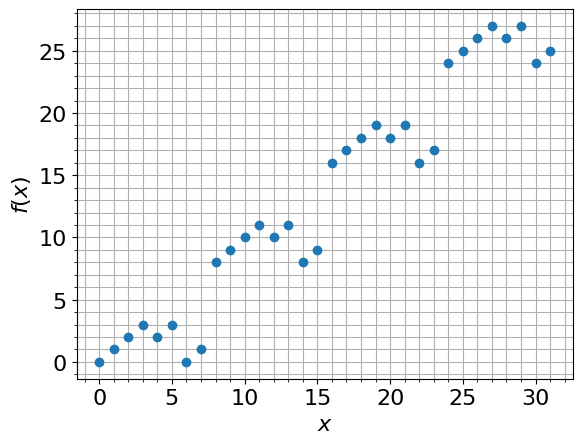

In [8]:
import matplotlib.pyplot as plt

my_result = {
    sample.state["x"]: sample.state["res"] for sample in result_1.parsed_counts
}
fig, ax = plt.subplots()
ax.plot(my_result.keys(), my_result.values(), "o")
ax.grid(axis="y", which="minor")
ax.grid(axis="y", which="major")
ax.grid(axis="x", which="minor")
ax.grid(axis="x", which="major")
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()

### Running the Simon's Algorithm

Taking $n$ number of shots guarantees getting a set of $n-1$ independent strings with high probability (assuming a noiseless quantum computer) (see [technical explanation](#The-quantum-part) below). Moreover, increasing the number of shots by a constant factor provides an exponential improvement. Here we take $50*n$ shots.

In [9]:
from classiq.execution import ExecutionPreferences


@qfunc
def main(x: Output[QNum[NUM_QUBITS]]):
    allocate(x)
    simon_qfunc(lambda x, res: simon_qfunc_simple(S_SECRET, x, res), x)


qmod_2 = create_model(
    main,
    constraints=Constraints(optimization_parameter=OptimizationParameter.WIDTH),
    # execution_preferences=ExecutionPreferences(num_shots=50 * NUM_QUBITS),
    out_file="simon_example",
)

We synthesize and execute to obtain the results: 

In [10]:
qprog_2 = synthesize(qmod_2)

# increasing the number of shots
prefs_more_shots = ExecutionPreferences(num_shots=50 * NUM_QUBITS)
with ExecutionSession(qprog_2, execution_preferences=prefs_more_shots) as es:
    result_2 = es.sample()

bitstrings = result_2.dataframe["bitstring"].tolist()
reversed_bitstrings = [b[::-1] for b in bitstrings]
samples = [[int(bit) for bit in b] for b in reversed_bitstrings]

In [11]:
matrix_of_ind_v = get_independent_set(samples)
# matrix_of_ind_v = [[0, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 1, 1], [1, 0, 1, 1, 1]]
assert (
    len(matrix_of_ind_v) == NUM_QUBITS - 1
), "Failed to find an independent set, try to increase the number of shots"
quantum_secret_integer = get_secret_integer(matrix_of_ind_v)

In [12]:
print("The secret binary string (integer) of f(x):", S_SECRET)
print("The result of the Simon's Algorithm:", quantum_secret_integer)
assert (
    S_SECRET == quantum_secret_integer
), "The Simon's algorithm failed to find the secret key."

The secret binary string (integer) of f(x): 6
The result of the Simon's Algorithm: 6


## Example: Shallow Simon's Function

In the second example we take a Simon's function that was presented in a recent paper [[4](#SimonsPaper2024)]: Take a secret string of the form $s=0^{n-l}1^l = \underbrace{00\dots0}_{n-l}\underbrace{1\dots111}_{l}~,$ and define the 2-to-1 function:
$$
f_{s}(|x\rangle_n) = \underbrace{|x_0\rangle |x_1\rangle \dots |x_{n-l-1}\rangle}_{n-l} |0\rangle \underbrace{|x_{n-l+1}\oplus x_{n-l}\rangle \dots |x_{n-1}\oplus x_{n-l}\rangle}_{l-1}.
$$
The function $f$ operates as follows: for the first $n-l$ elements, we simply "copy" the data, whereas for the last $l$ elements we apply a xor with the $n-l$ element. A simple proof that this is indeed a 2-to-1 function is given in Ref. [[4](#SimonsPaper2024)].

*Comment:* Ref. [[4](#SimonsPaper2024)] employed further reduction of the function implementation (reducing the $n$-sized Simon's problem to an $(n-l)$-sized problem), added a classical postprocess of randomly permutating over the result of $f(x)$ to increase the hardness of the problem, and also included some NISQ analysis. These steps were taken to show an algorithmic speedup on real quantum hardware.

### Implementing the Simon's Function

The first $n-l$ "classical copies", $|x_k,0\rangle\rightarrow |x_k x_k\rangle$, can be implemented by $CX$ gates. The xor operations, $|x_k,0\rangle\rightarrow |x_k, x_k \oplus x_{n-l}\rangle$, can be implemented by two $CX$ operations, one to form a "classical copy" of $x_k$, followed by another $CX$ operation, implementing a xor with $x_{n-l}$.

In [13]:
@qperm
def simon_qfunc_with_bipartite_s(
    partition_index: CInt, x: Const[QArray], res: Output[QArray]
):
    allocate(x.len, res)

    repeat(x.len - partition_index, lambda i: CX(x[i], res[i]))
    repeat(
        partition_index - 1,
        lambda i: (
            CX(
                x[x.len - partition_index + 1 + i],
                res[x.len - partition_index + 1 + i],
            ),
            CX(x[x.len - partition_index], res[x.len - partition_index + 1 + i]),
        ),
    )

Here we take a specific example and plot $f(x)$ for all possible $x$ values: 

Quantum program link: https://platform.classiq.io/circuit/34mVDOXLAzcRdHDm1MdfrWt5t2c


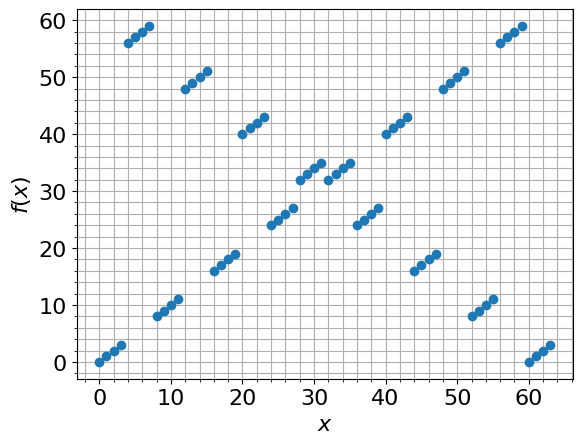

In [14]:
NUM_QUBITS = 6
PARTITION_INDEX = 4


@qfunc
def main(x: Output[QNum[NUM_QUBITS]], res: Output[QNum]):
    allocate(x)
    hadamard_transform(x)
    simon_qfunc_with_bipartite_s(PARTITION_INDEX, x, res)


# create model
qmod_3 = create_model(main)
# synthesize
qprog_3 = synthesize(
    qmod_3, constraints=Constraints(optimization_parameter=OptimizationParameter.DEPTH)
)
# vizualize
show(qprog_3)

# execute
result_3 = execute(qprog_3).result_value()

# plot the f(x)
my_result = {
    sample.state["x"]: sample.state["res"] for sample in result_3.parsed_counts
}
fig, ax = plt.subplots()
ax.plot(my_result.keys(), my_result.values(), "o")
ax.grid(axis="y", which="minor")
ax.grid(axis="y", which="major")
ax.grid(axis="x", which="minor")
ax.grid(axis="x", which="major")
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()

### Running the Simon's Algorithm

As in the first example, we take $50*n$ shots.

In [15]:
@qfunc
def main(x: Output[QNum[NUM_QUBITS]]):
    allocate(x)
    simon_qfunc(lambda x, res: simon_qfunc_with_bipartite_s(PARTITION_INDEX, x, res), x)


qmod_4 = create_model(main)
# qmod_4 = update_execution_preferences(qmod_4, num_shots=50 * NUM_QUBITS)
write_qmod(qmod_4, "simon_shallow_example")

We synthesize and execute to obtain the results: 

In [16]:
qprog_4 = synthesize(qmod_4)
show(qprog_4)

# increasing the number of shots
prefs_more_shots = ExecutionPreferences(num_shots=50 * NUM_QUBITS)
with ExecutionSession(qprog_4, execution_preferences=prefs_more_shots) as es:
    result_4 = es.sample()

bitstrings = result_4.dataframe["bitstring"].tolist()
reversed_bitstrings = [b[::-1] for b in bitstrings]
samples = [[int(bit) for bit in b] for b in reversed_bitstrings]

Quantum program link: https://platform.classiq.io/circuit/34mVDqzmoTjehvE8NRcU9gOqrdC


In [17]:
matrix_of_ind_v = get_independent_set(samples)
assert (
    len(matrix_of_ind_v) == NUM_QUBITS - 1
), "Failed to find an independent set, try to increase the number of shots"
quantum_secret_integer = get_secret_integer(matrix_of_ind_v)

In [18]:
s_secret = int("1" * PARTITION_INDEX + "0" * (NUM_QUBITS - PARTITION_INDEX), 2)
print("The secret binary string (integer) of f(x):", s_secret)
print("The result of the Simon's Algorithm:", quantum_secret_integer)
assert (
    s_secret == quantum_secret_integer
), "The Simon's algorithm failed to find the secret key."

The secret binary string (integer) of f(x): 60
The result of the Simon's Algorithm: 60


## Technical Notes

This section provides some technical details about the quantum and classical parts of the Simon's algorithm.

### Quantum Part

Following the three blocks of the algorithm:
$$
|0\rangle_n |0\rangle_n  \xrightarrow[H^{\otimes n}]{} \frac{1}{2^{n/2}}\sum^{2^n-1}_{x=0}|x\rangle_n |0\rangle_n  \xrightarrow[\text{Oracle(f(x))}]{} \frac{1}{2^{n/2}}\sum^{2^n-1}_{x=0}|x\rangle_n |f(x)\rangle_n 
 \xrightarrow[H^{\otimes n}]{} \frac{1}{2^{n}} \sum^{2^n-1}_{y=0} |y\rangle_n \left( \sum^{2^n-1}_{x=0}(-1)^{x\cdot y} |f(x)\rangle_n \right)~~.
$$
We next measure the first register $|y\rangle$. First, we treat the case where $s\neq 0$ that $f(x)$ is a 2-to-1 function. The claim is that for any measured state $y$, we must have that $y\cdot s=0$. To see this, calculate the probability of measuring some state $|y\rangle$:
$$
P(|y\rangle) \propto \left| \sum^{2^n-1}_{x=0}(-1)^{x\cdot y} |f(x)\rangle_n \right|^2.
$$
Now, change the sum to run over the image of $f(x)$ instead of over all $x\in [0,2^{n}-1]$. Since for any $f(x)$ there are two sources in the domain, $x$ and $x\oplus s$,  we can write
$$
P(|y\rangle) \propto \left| \sum_{f(x) \in imag(f)} \left[ (-1)^{x\cdot y} + (-1)^{(x\oplus s )\cdot y} \right]|f(x)\rangle_n \right|^2.
$$
Since $$  (-1)^{x\cdot y} + (-1)^{(x\oplus s )\cdot y}  =  (-1)^{x\cdot y}( 1+ (-1)^{s\cdot y})$$ vanishes when  $s\cdot y \neq 0 ~(\text{mod}~ 2)$, for any measured $y$ we have $y\cdot s = 0$. Therefore, every measurement $y$ gives a random vector orthogonal to $s$. Repeating $O(n)$ measurements collects $n-1$ linear modular equations which span the orthogonal space to $s$. 

### Classical Part

We have a set of possible $y$ values that can be measured, each with a probability of $1/M$, where $M$ is the set size. If $s=0^n$, we have $M=2^n$, whereas for $s\neq 0^n$ the set size is $M=2^{n-1}$. The probability of measuring a set of $n-1$ linearly independent binary strings $y$ can be calculated as follows (see also the birthday problem [[2](#BDWiki)]): For the first string, $y_0$, we just require that we do not pick $y=0^n$, so $P(y_0)=1-1/M$. Then, for the next string, we require that it is not in $\left\{a_0 y_0\,\,\,| a_0=0,1\right\}$, thus $P(y_1)=(1-2/M)$. The following string must not be picked out of $\left\{a_0 y_0+a_1y_1\,\,\,| a_0, a_1=0,1\right\}$, thus $P(y_2)=(1-2^2/M)$. We can continue with this procedure up to $y_{n-2}$ (in total $n-1$ vectors) to get
$$
P_{\rm independent} = 
\left\{\begin{array}{l l}
\Pi^{n-2}_{k=0} \left(1-2^k/2^{n}\right) & \text{,  if } f(x) \text{ is 1-to-1},\\
\Pi^{n-2}_{k=0} \left(1-2^k/2^{n-1}\right) & \text{,   if } f(x) \text{ is 2-to-1}
\end{array}
\,\,\,\,\,
\geq \Pi^{\infty}_{k=1}\left(1-\frac{1}{2^k}\right) \approx 0.2887 \geq 1/4.
\right.
$$
If we repeat the experiment, the probability of measuring an independent set improves exponentially.
Solving the linear system recovers $s$.

## Reference

<a id='original-paper'>[1]</a> [ Simon, D. R. (1997). On the power of quantum computation. SIAM journal on computing, 26(5), 1474-1483.](https://epubs.siam.org/doi/abs/10.1137/S0097539796298637)

<a id='SimonsWiki'>[2]</a> [ Simon's Algorithm (Wikipedia).](https://en.wikipedia.org/wiki/Simon%27s_problem)

<a id='BDWiki'>[3]</a> [Birthday problem. ](https://en.wikipedia.org/wiki/Birthday_problem)

<a id='SimonsPaper2024'>[4]</a> [Singkanipa P. et al. Demonstration of Algorithmic Quantum Speedup for an Abelian Hidden Subgroup Problem. ](https://arxiv.org/abs/2401.07934)
